# Chapter 3: Defining computation

This notebook contains code related to **Chapter 3: Defining Computation**.

In [1]:
# utility code 
%run "Utilities.ipynb"
from IPython.display import clear_output
clear_output()

In [10]:
def AND(a,b): return a*b

def OR(a,b): return 1 if a+b else 0

def NOT(a): return 1-a

In [11]:
def EVAL(code,X):
    """Evaluate code on input X."""
    n,m = numinout(code) # helper function - get number of inputs and outputs
    
    vtable = { f"X[{i}]":int(X[i]) for i in range(n)}
    
    for line in code.split("\n"):
        if not line: continue
        foo,op,bar,blah = parseline(line,2) 
        # helper function - split "foo = OP(,blah)" to list ["foo","OP","bar","blah"]
        # 2 is num of arguments to expect: blah is empty if it's missing
        if op=="NOT": vtable[foo] = NOT(vtable[bar])
        if op=="AND": vtable[foo] = AND(vtable[bar],vtable[blah])
        if op=="OR": vtable[foo] =  OR(vtable[bar],vtable[blah])
    
    return [vtable[f"Y[{j}]"] for j in range(m)]            

In [12]:
majcode = r"""firstpair  = AND(X[0],X[1])
secondpair = AND(X[1],X[2])
thirdpair  = AND(X[0],X[2])
temp       = OR(secondpair,thirdpair)
Y[0] =  OR(firstpair,temp)
"""

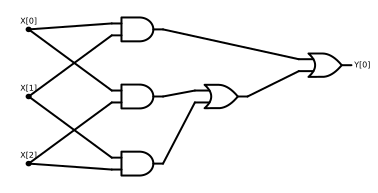

In [31]:
C = prog2circuit(majcode)
schemdraw(C,filename="majaoncircuit.png")

In [36]:
code = r"""
t1      = AND(X[0],X[1])
notx0   = NOT(X[0])
t2      = AND(notx0,X[2])
Y[0]    = OR(t1,t2)
"""[1:]

In [37]:
EVAL(code,"010")

[0]

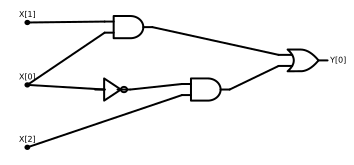

In [45]:
prog2circuit(code)

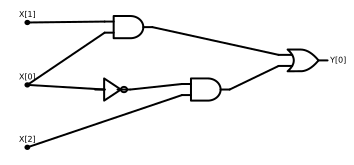

In [46]:
C = prog2circuit(code)
schemdraw(C)

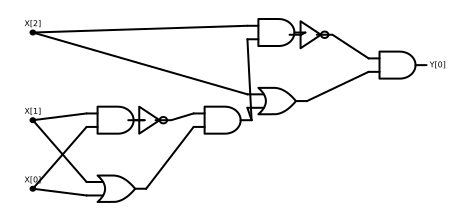

In [48]:
def XOR3(a,b,c):
    w1 = AND(a,b)
    w2 = NOT(w1)
    w3 = OR(a,b)
    w4 = AND(w2,w3)
    w5 = AND(w4,c)
    w6 = NOT(w5)
    w7 = OR(w4,c)
    return AND(w6,w7)

drawcirc(XOR3)

In [19]:
def AON2NAND(code):
    """Translate an AON-CIRC program to an equivalent NAND-CIRC program"""
    output = ""
    counter = 0
    for line in code.split("\n"):
        if not line: continue
        foo,op,bar,blah = parseline(line,2) 
        if op=="NOT":
            output += f"{foo} = NAND({bar},{bar})\n"
        if op=="AND": 
            output += f"temp_{counter} = NAND({bar},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter})\n"
            counter +=1
        if op=="OR":
            output += f"temp_{counter} = NAND({bar},{bar})\n"
            output += f"temp_{counter+1} = NAND({blah},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter+1})\n"
            counter +=2
    return output

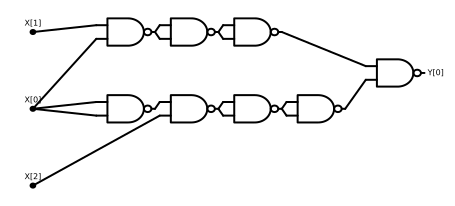

In [20]:
C = prog2circuit(AON2NAND(code))
schemdraw(C)

In [21]:
def BIG1(a,b):
    t = NOT(b)
    return OR(a,t)

def BIG2(X):
    """Input is X[0]...X[3] which we consider as two three-bit numbers A and B. We return 1 iff A>B"""
    y1 = BIG1(X[0],X[2])
    n1 = BIG1(X[2],X[0])
    y2 = BIG1(X[1],X[3])
    t  = AND(y2,n1)
    return OR(y1,t)

In [22]:
code = circuit2prog(circuit(BIG2,4))
print(code)

gate_0 = NOT(X[2])
gate_1 = OR(X[0],gate_0)
gate_2 = NOT(X[0])
gate_3 = OR(X[2],gate_2)
gate_4 = NOT(X[3])
gate_5 = OR(X[1],gate_4)
gate_6 = AND(gate_5,gate_3)
Y[0] = OR(gate_1,gate_6)



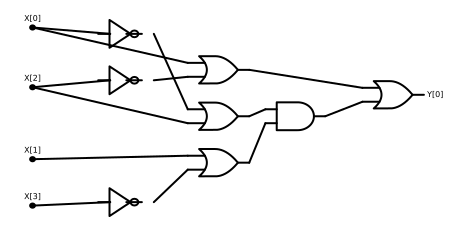

In [23]:
C = prog2circuit(code)
schemdraw(C)

In [24]:
BIG2([1,0,0,1])

1

In [25]:
BIG1(1,0)

1

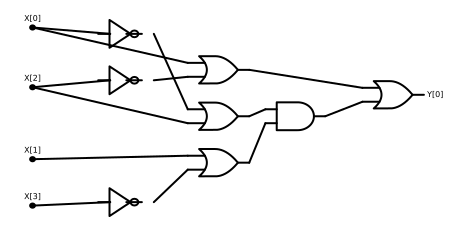

In [26]:
C = prog2circuit(code)
C

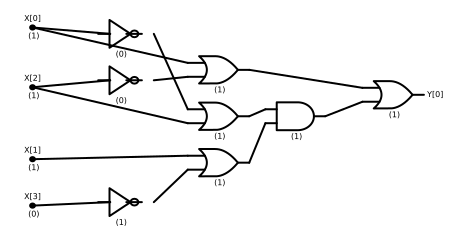

In [27]:
C.render_eval(1,1,1,0)

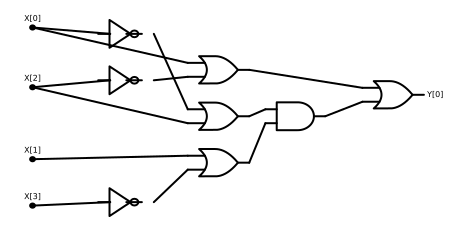

In [28]:
schemdraw(C)

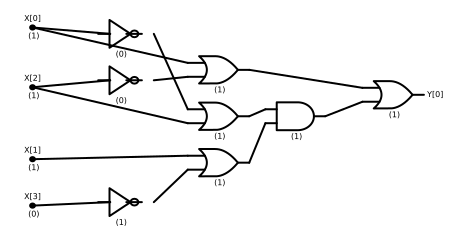

In [29]:
schemdraw(C,[1,1,1,0])

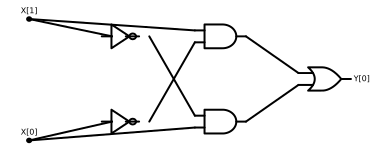

In [30]:
xorcode = r'''notx0 = NOT(X[0])
notx1 = NOT(X[1])
a = AND(X[1],notx0)
b = AND(X[0],notx1)
Y[0] = OR(a,b)
'''
prog2circuit(xorcode)

In [ ]:
C = prog2circuit(xorcode)
schemdraw(C) 

In [ ]:
schemdraw(C,[1,0])

In [ ]:
def ALLEQ(a,b,c,d):
    t = AND(AND(AND(a,b),c),d)
    u = AND(AND(AND(NOT(a),NOT(b)),NOT(c)),NOT(d))
    return OR(t,u)

In [ ]:
drawcirc(ALLEQ)

In [ ]:
CMPcode = r'''temp_1 = NOT(X[2])
temp_2 = OR(X[0],temp_1)
temp_3 = NOT(X[0])
temp_4 = OR(X[2],temp_3)
temp_5 = NOT(X[3])
temp_6 = OR(X[1],temp_5)
temp_7 = AND(temp_6,temp_4)
Y[0] = OR(temp_2,temp_7)
'''
schemdraw(prog2circuit(CMPcode),[1,1,1,0])

In [ ]:
print(function2code(XOR3))

In [ ]:
code = r'''
temp_1 = NOT(X[2])
temp_2 = AND(X[0],temp_1)
temp_3 = OR(X[0],temp_1)
temp_4 = NOT(X[3])
temp_5 = AND(X[1],temp_4)
temp_6 = AND(temp_5,temp_3)
Y[0] = OR(temp_2,temp_6)
'''
C = circuit(code)
for a in [0,1]:
    for b in [0,1]:
        for c in [0,1]:
            for d in [0,1]:
                print(((a>c) or ((a==c) and (b>d)))==C(a,b,c,d))

In [ ]:
drawcirc(XOR3)

# NAND circuits

In [ ]:
code = r'''u = NAND(X[0],X[1])
v = NAND(X[0],u)
w = NAND(X[1],u) 
Y[0] = NAND(v,w)
'''

In [ ]:
def XORN(a,b):
    u = NAND(a,b)
    v = NAND(a,u)
    w = NAND(b,u)
    return NAND(v,w)

def XOR3(a,b,c):
    return XORN(XORN(a,b),c)

print(function2code(XOR3))
drawcirc(XOR3)

In [ ]:
drawcirc(XORN)

In [ ]:
temp_1 = NAND(X[0],X[1])
temp_2 = NAND(X[0],temp_1)
temp_3 = NAND(X[1],temp_1)
temp_4 = NAND(temp_2,temp_3)
temp_5 = NAND(temp_4,X[2])
temp_6 = NAND(temp_4,temp_5)
temp_7 = NAND(X[2],temp_5)
Y[0] = NAND(temp_6,temp_7)

In [ ]:
def MAJ3(a,b,c):
    return OR(OR(AND(a,b),AND(b,c)),AND(a,c))

drawcirc(MAJ3,NANDONLY=True)

# Increment

In [ ]:
def one(a):
    return NAND(a,NAND(a,a))

def INC(X):
    n = len(X)
    Y=[0]*(n+1)
    c = one(X[0])
    for i in range(n):
        Y[i] = XORN(c,X[i])
        c = AND(X[i],c)
    Y[n] = c
    return Y
    

In [ ]:
drawcirc(INC,4,NANDONLY=True)


# Neural net activation functions

In [ ]:
import numpy as np
import matplotlib.pylab as plt


def step(x):
    return np.array(x > 0, dtype=np.int)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, 0.2*x)

def mytanh(x):
    return 0.5*np.tanh(x)+0.5

x = np.arange(-5.0, 5.0, 0.1)
y_step = step(x)
y_sigmoid = sigmoid(x)
y_relu = relu(x)
y_tanh = mytanh(x)

plt.plot(x, y_step, label='Step', color='r', lw=1, linestyle=None)
plt.plot(x, y_sigmoid, label='Sigmoid', color='g', lw=1, ls='--')
plt.plot(x, y_relu, label='ReLU(0.2x)', color='b', lw=1, linestyle='-.')
plt.plot(x, y_tanh, label='0.5tanh+0.5',color='y',lw=1,linestyle=':')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

In [ ]:
code = r'''temp_0 = NAND(X[0],X[0])
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
'''

In [ ]:
code = r'''temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker[i] = NAND(X_nonblank[i],X_noblank[i])
Atend[i] = NAND(X_nonblank[i],X_nonblank[i])
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
'''

In [ ]:
temp_0 = NAND(X[0],X[0])
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
MODANDJUMP(X_nonblank[i],X_nonblank[i])
    

In [ ]:
temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker[i] = NAND(X_nonblank[i],X_noblank[i])
Atend[i] = NAND(X_nonblank[i],X_nonblank[i])
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
MODANDJUMP(X_nonblank[i],X_nonblank[i])

In [ ]:
res = ""
for i in [0,1,2,3]:
    res += code.replace('[i]',f'[{i}]')
print(res)

In [ ]:
res = r'''temp_0 = NAND(X[0],X[0])
temp_2 = NAND(X[0],temp_0)
temp_3 = NAND(X[0],temp_2)
temp_4 = NAND(temp_0,temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_2 = NAND(X[1],Y[0])
temp_3 = NAND(X[1],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_2 = NAND(X[2],Y[0])
temp_3 = NAND(X[2],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_2 = NAND(X[3],Y[0])
temp_3 = NAND(X[3],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
'''
C = prog2circuit(res)
schemdraw(C)

In [ ]:
temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker_0 = NAND(X_nonblank_0,X_noblank_0)
Atend_0 = NAND(X_nonblank_0,X_nonblank_0)
temp_2 = NAND(X_0,Y[0])
temp_3 = NAND(X_0,temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker_1 = NAND(X_nonblank_1,X_noblank_1)
Atend_1 = NAND(X_nonblank_1,X_nonblank_1)
temp_2 = NAND(X_1,Y[0])
temp_3 = NAND(X_1,temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker_2 = NAND(X_nonblank_2,X_noblank_2)
Atend_2 = NAND(X_nonblank_2,X_nonblank_2)
temp_2 = NAND(X_2,Y[0])
temp_3 = NAND(X_2,temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker_3 = NAND(X_nonblank_3,X_noblank_3)
Atend_3 = NAND(X_nonblank_3,X_nonblank_3)
temp_2 = NAND(X_3,Y[0])
temp_3 = NAND(X_3,temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)